# Import librairies

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
import re

# Import dataset

In [2]:
df_dechets = pd.read_csv("https://raw.githubusercontent.com/murpi/supdevinci/refs/heads/main/ML/tri_selectif.csv")


# Exploration

In [3]:
df_dechets.head()

,product,metal,width,optical_code,height_40,height_70,height_110,height_200,timestamp_first,timestamp_last
0,dechet,False,86,T033073,True,True,False,False,2024-11-14 14:40:59.955602,2024-11-14 14:40:59.994822
1,dechet,False,79,T047103,True,True,False,False,2024-11-14 14:41:00.075113,2024-11-14 14:41:00.103905
2,carton_petit,False,89,B121025,True,True,False,False,2024-11-14 14:41:00.226855,2024-11-14 14:41:00.277602
3,tetrapak,False,71,B103004,True,False,False,False,2024-11-14 14:41:00.375405,2024-11-14 14:41:00.412324
4,bouteille_t,False,203,T049064,True,False,False,False,2024-11-14 14:41:00.475034,2024-11-14 14:41:00.497214


In [4]:
df_dechets.shape

(10000, 10)

In [5]:
df_dechets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   product          10000 non-null  object
 1   metal            10000 non-null  bool  
 2   width            10000 non-null  int64 
 3   optical_code     10000 non-null  object
 4   height_40        10000 non-null  bool  
 5   height_70        10000 non-null  bool  
 6   height_110       10000 non-null  bool  
 7   height_200       10000 non-null  bool  
 8   timestamp_first  10000 non-null  object
 9   timestamp_last   10000 non-null  object
dtypes: bool(5), int64(1), object(4)
memory usage: 439.6+ KB


In [6]:
df_dechets.isna().sum()

product            0
metal              0
width              0
optical_code       0
height_40          0
height_70          0
height_110         0
height_200         0
timestamp_first    0
timestamp_last     0
dtype: int64

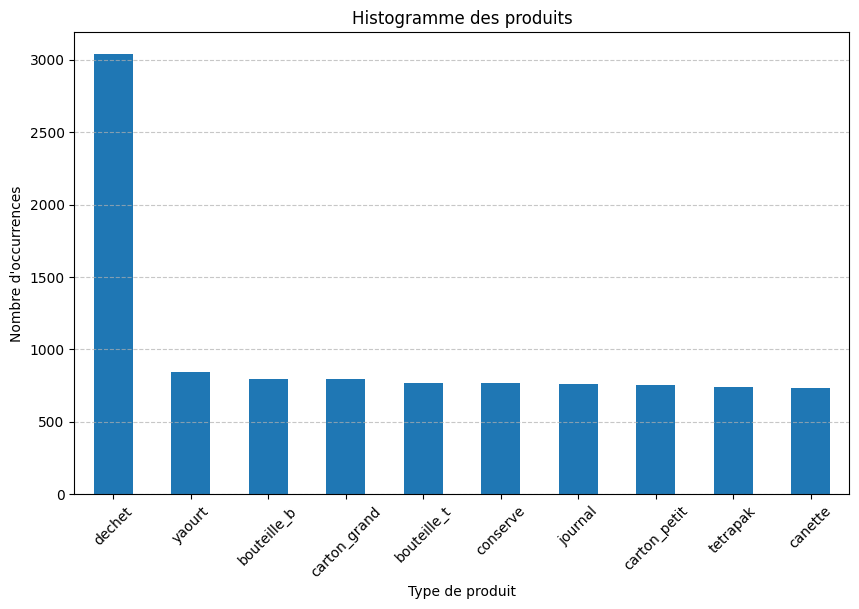

In [7]:
product_counts = df_dechets['product'].value_counts()

# Créer un histogramme
plt.figure(figsize=(10, 6))
product_counts.plot(kind='bar')
plt.title('Histogramme des produits')
plt.xlabel('Type de produit')
plt.ylabel('Nombre d\'occurrences')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Réquilibre des classes

In [8]:
# Classe majoritaire : "déchet"
majority_class = df_dechets[df_dechets['product'] == 'dechet']

# Classes minoritaires
minority_classes = df_dechets[df_dechets['product'] != 'dechet']

# Taille cible (par exemple, la moyenne des autres classes)
target_size = minority_classes['product'].value_counts().mean()

# Undersampling de la classe majoritaire
majority_downsampled = resample(majority_class,
                                replace=False,          # Pas de duplication
                                n_samples=int(target_size),  # Taille cible
                                random_state=42)     

# Combiner les classes rééquilibrées
df_balanced = pd.concat([majority_downsampled, minority_classes])

# Mélange des données
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


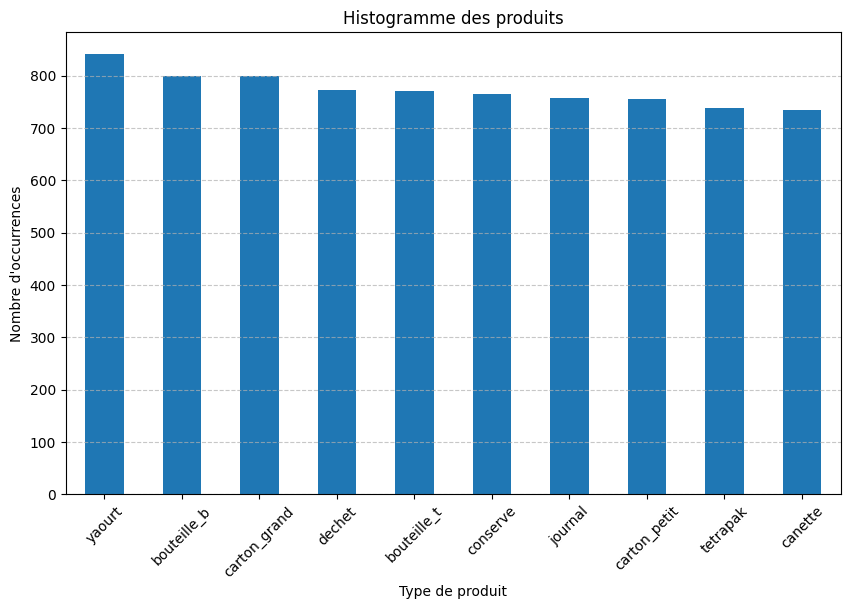

In [9]:
# Vérification
product_counts = df_balanced['product'].value_counts()

# Créer un histogramme
plt.figure(figsize=(10, 6))
product_counts.plot(kind='bar')
plt.title('Histogramme des produits')
plt.xlabel('Type de produit')
plt.ylabel('Nombre d\'occurrences')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### Encodage optical_code brut

In [10]:
def encodage_categoriel(colonne_name) :
    unique_value= sorted(df_balanced[colonne_name].unique())
    Ordencod_optical_code = OrdinalEncoder(categories=[unique_value])
    df_balanced[f'{colonne_name}_Encoded'] = Ordencod_optical_code.fit_transform(df_balanced[[colonne_name]])

In [11]:
encodage_categoriel('optical_code') 

### Encodage optical_code sans lettre

In [12]:
def remove_letter (value) :
    result = re.sub(r'[a-zA-Z]', '', value)
    return result

In [13]:
df_balanced['optical_code_numerical_only'] = df_balanced['optical_code'].apply(remove_letter)

In [14]:
encodage_categoriel('optical_code_numerical_only')

### Encodage optical_code en colonne séparée

In [15]:
def separate_data_optical_code(value) :
    letter = value[0]
    transparency = value[1:4]
    teinte = value[4:7]
    return letter, transparency, teinte

In [16]:
df_balanced[['colorimetrie', 'transparency', 'teinte']] = df_balanced['optical_code'].apply(
    separate_data_optical_code
).apply(pd.Series)

In [17]:
df_balanced['colorimetrie_Encoded'], uniques = pd.factorize(df_balanced['colorimetrie'])
encodage_categoriel('transparency')
encodage_categoriel('teinte')

## Ajout de la longeur

In [18]:
def calculer_longeur_mm(df): 
    """
    Calcule la colonne 'taille_mm' à partir des colonnes 'timestamp_first' et 'timestamp_last' d'un DataFrame.
    
    Paramètres :
        df (pd.DataFrame) : DataFrame contenant les colonnes 'timestamp_first' et 'timestamp_last'.
        
    Retourne :
        pd.Series : Colonne 'taille_mm' avec les tailles calculées en millimètres.
    """
    # Convertir les colonnes en type datetime
    df['timestamp_first'] = pd.to_datetime(df['timestamp_first'])
    df['timestamp_last'] = pd.to_datetime(df['timestamp_last'])
    
    # Calculer la différence en secondes
    df['écart_seccondes'] = (df['timestamp_last'] - df['timestamp_first']).dt.total_seconds()
    
    # Calculer la vitesse en km/s (8 km/h)
    vitesse_km_s = 8 / 3600  # Conversion de 8 km/h en km/s
    
    df['distance_km'] = df['écart_seccondes'] * vitesse_km_s
    
    df['longeur_mm'] = (df['distance_km'] * 1000000).round(2)
    df.drop(columns=['distance_km', 'écart_seccondes'],inplace=True)
    return df

In [19]:
calculer_longeur_mm(df_balanced)

In [20]:
df_balanced.columns

Index(['product', 'metal', 'width', 'optical_code', 'height_40', 'height_70',
       'height_110', 'height_200', 'timestamp_first', 'timestamp_last',
       'optical_code_Encoded', 'optical_code_numerical_only',
       'optical_code_numerical_only_Encoded', 'colorimetrie', 'transparency',
       'teinte', 'colorimetrie_Encoded', 'transparency_Encoded',
       'teinte_Encoded', 'longeur_mm'],
      dtype='object')

## Ajout colonne hauteur

In [21]:
df_balanced['height_110']


0        True
1       False
2        True
3       False
4        True
        ...  
7729    False
7730    False
7731    False
7732     True
7733    False
Name: height_110, Length: 7734, dtype: bool

In [22]:
def determine_height(row):
    if not row['height_40'] and not row['height_70'] and not row['height_110'] and not row['height_200']:
        return '[0, 40]'
    if row['height_40'] and not row['height_70'] and not row['height_110'] and not row['height_200']:
        return '[40, 70]'
    elif row['height_40'] and row['height_70'] and not row['height_110'] and not row['height_200']:
        return '[70, 110]'
    elif  row['height_40'] and row['height_70'] and row['height_110'] and not row['height_200']:
        return '[110, 200]'
    elif row['height_40'] and row['height_70'] and row['height_110'] and row['height_200']:
         return '>= 200'
    else:
        return 'Undefined'


In [23]:
# Appliquer la fonction pour créer la colonne 'height'
df_balanced['height'] = df_balanced.apply(determine_height, axis=1)

# Afficher le DataFrame mis à jour
print(df_balanced['height'])

0       [110, 200]
1        [70, 110]
2           >= 200
3         [40, 70]
4       [110, 200]
           ...    
7729      [40, 70]
7730     [70, 110]
7731       [0, 40]
7732        >= 200
7733      [40, 70]
Name: height, Length: 7734, dtype: object


In [24]:
undefined_height = df_balanced[df_balanced['height'] == 'Undefined']
undefined_height.shape

(0, 21)

In [25]:
height_encoder = {
    '[0, 40]': 1,
    '[40, 70]': 2,
    '[70, 110]': 3,
    '[110, 200]': 4,
    '>= 200': 5
}

# Encoder la colonne 'height'
df_balanced['height_encoded'] = df_balanced['height'].map(height_encoder)

# Afficher les premières lignes pour vérifier
print(df_balanced[['height', 'height_encoded']])


          height  height_encoded
0     [110, 200]               4
1      [70, 110]               3
2         >= 200               5
3       [40, 70]               2
4     [110, 200]               4
...          ...             ...
7729    [40, 70]               2
7730   [70, 110]               3
7731     [0, 40]               1
7732      >= 200               5
7733    [40, 70]               2

[7734 rows x 2 columns]
